In [174]:
%%html
<h1 style="text-align: center; font-size: 8rem">Act-II</h1>
<h2>Steps:</h2>
<ol>
    <li>Feature engineering</li>
    <li>Hyperparameter tuning</li>
    <li>Feature selection(feature importances, shap)</li>
    <li>More hyperparameter tuning and building final model</li>
    <li>submit & check the score</li>
</ol>

**To-do** 

* skewness in features
* outlier detection and removal

In [175]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports & Config

In [204]:
# imports

import json
import warnings
from collections import namedtuple
from datetime import datetime
from pathlib import Path

import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from joblib import dump, load
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, LabelEncoder
from matplotlib import pyplot as plt

In [177]:
if Path("/kaggle/input").exists():
    dataset_path = Path("/kaggle/input/house-prices-advanced-regression-techniques")
    result_path = Path("/kaggle/working/")
else:
    dataset_path = Path("./dataset/")
    result_path = Path("./results")
    result_path.mkdir(parents=True, exist_ok=True)
    
[_.name for _ in dataset_path.iterdir()]

['data_description.txt',
 'train.csv',
 '.ipynb_checkpoints',
 'test_ftrs_added.csv',
 'train_with_folds.csv',
 'test.csv',
 'sample_submission.csv',
 'test_with_folds.csv',
 'train_ftrs_added.csv']

In [178]:
# config

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
plt.style.use("ggplot")
warnings.filterwarnings("ignore")

In [179]:
# notebook level variables

N_SPLITS = 7
random_seed = 13

# Load dataset

In [180]:
train_df = pd.read_csv(dataset_path/"train.csv")
test_df = pd.read_csv(dataset_path/"test.csv")
sample_subm_df = pd.read_csv(dataset_path/"sample_submission.csv")

train_df.shape, test_df.shape

((1460, 81), (1459, 80))

# Create folds

In [181]:
kfold = KFold(n_splits=N_SPLITS, random_state=random_seed, shuffle=True)

# add a fold_no column to train_df
next(kfold.split(train_df))
for fold_no, (train_ix, test_ix) in enumerate(kfold.split(train_df)):
    train_df.loc[test_ix, "fold_no"] = fold_no
    
train_df.fold_no.value_counts()

1.0    209
0.0    209
3.0    209
2.0    209
6.0    208
4.0    208
5.0    208
Name: fold_no, dtype: int64

# Variable study

## Target variable

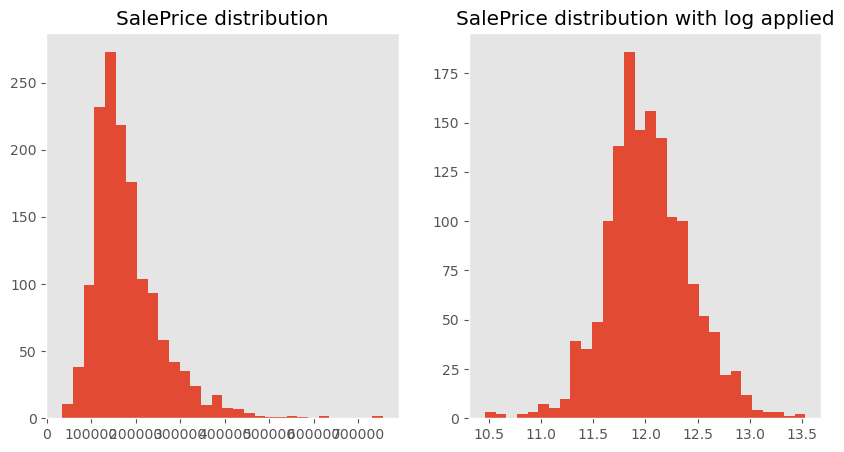

In [182]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].hist(train_df.SalePrice, bins=30)
ax[0].set_title("SalePrice distribution")
ax[1].hist(np.log1p(train_df.SalePrice), bins=30)
ax[1].set_title("SalePrice distribution with log applied")
[ax[_].grid(False) for _ in range(0, 2)]
plt.show()

In [183]:
# Target skewness correction

train_df["log_SalePrice"] = train_df.SalePrice.apply(np.log1p)

## Identifying different type of columns

In [184]:
useful_cols = [col for col in train_df.columns if col not in ["SalePrice", "log_SalePrice", "Id", "fold_no"]]
len(useful_cols)

79

In [185]:
ordinal_cols = [
    "MSSubClass",
    "LotShape",
    "LandSlope",
    "OverallQual",
    "OverallCond",
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "HeatingQC",
    "KitchenQual",
    "Functional",
    "FireplaceQu",
    "GarageQual",
    "GarageFinish",
    "GarageCond",
    "PoolQC",
    "Fence",
]

num_cols = [
    "LotFrontage",
    "LotArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    # can they be ordinal columns
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    #
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "MasVnrArea",
]

cat_cols = [
    "MSZoning",
    "Street",
    "Alley",
    "LandContour",  # can it be an ordinal variable
    "Utilities",
    "LotConfig",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "Foundation",
    "Heating",
    "CentralAir",
    "Electrical",
    "GarageType",
    "PavedDrive",
    "MiscFeature",
    "MoSold",
    "SaleType",
    "SaleCondition",
]

year_cols = [
    "GarageYrBlt",
    "YearBuilt",
    "YrSold",
    "YearRemodAdd",
]


## Filling nulls

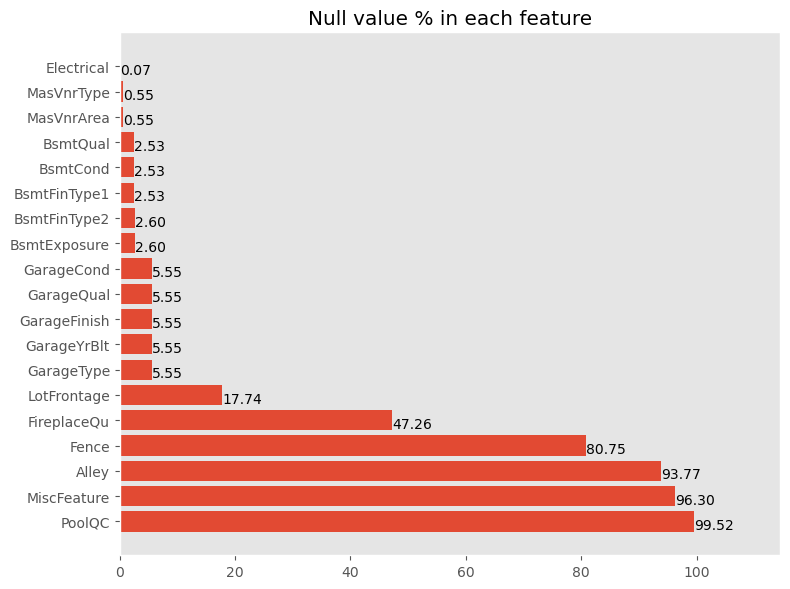

In [186]:
train_na_df = (
    train_df.isnull()
    .sum()
    .where(lambda x: x > 0)
    .dropna()
    .sort_values(ascending=False)
    .reset_index()
)
train_na_df.columns = ["col_name", "value"]
train_na_df["pct"] = train_na_df.value * 100 / len(train_df)

plt.figure(figsize=(8, 6))
plt.barh(y=train_na_df.col_name, width=train_na_df.pct)
for ix, row in train_na_df.iterrows():
    plt.text(row["pct"], ix - 0.3, f'{row["pct"]:.2f}')

plt.title("Null value % in each feature")
plt.grid(False)
plt.margins(x=0.15)
plt.tight_layout()
plt.show()

In [187]:
# remove features with null percentage > 40

null_cols = train_na_df[train_na_df.pct > 40].col_name.tolist()
print(null_cols)
useful_cols = [col for col in useful_cols if col not in null_cols]

ordinal_cols = list(set(ordinal_cols).intersection(useful_cols))
cat_cols = list(set(cat_cols).intersection(useful_cols))
num_cols = list(set(num_cols).intersection(useful_cols))
year_cols = list(set(year_cols).intersection(useful_cols))

try:
    train_df.drop(null_cols, axis=1, inplace=True)
    test_df.drop(null_cols, axis=1, inplace=True)
except:
    pass

train_df.shape, test_df.shape

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']


((1460, 78), (1459, 75))

### Observations

1. Null values in GarageType, GarageFinish, GarageYrBlt, GarageQual, GarageCond could be becuase of "No Garage" in the house. We can fill "NA" in those columns.
2. Same with with basement columns; BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, BsmtCond

In [188]:
na_fill_values = {
    "PoolQC": "NA",
    "MiscFeature": "NA",
    "Alley": "NA",
    "Fence": "NA",
    "BsmtExposure": "NA",
    "BsmtFinType2": "NA",
    "BsmtFinType1": "NA",
    "BsmtQual": "NA",
    "BsmtCond": "NA",
    "GarageType": "NA",
    "GarageFinish": "NA",
    "GarageQual": "NA",
    "GarageCond": "NA",
    "FireplaceQu": "NA",
}

In [189]:
# fill na values

train_df.fillna(value=na_fill_values, inplace=True)
test_df.fillna(value=na_fill_values, inplace=True)

lets drop GarageYrBlt - why?
1. It's a non-measurable column
1. wherever it is null, it means garage is not present in the house

So, let's create a new feature whether there is a garage in the house

In [190]:
try:
    train_df["GaragePresent"] = ~train_df["GarageYrBlt"].isnull()
    test_df["GaragePresent"] = ~test_df["GarageYrBlt"].isnull()

    train_df.drop("GarageYrBlt", axis=1, inplace=True)
    test_df.drop("GarageYrBlt", axis=1, inplace=True)
    year_cols.remove("GarageYrBlt")
except KeyError as e:
    print(e)

## Creating new features

In [191]:
def add_features_to_df(df):
    df["SqFtPerRoom"] = df["GrLivArea"] / (df["TotRmsAbvGrd"] +
                                           df["FullBath"] +
                                           df["HalfBath"] +
                                           df["KitchenAbvGr"])
    df["TotalHomeQual"] = df["OverallQual"] + df["OverallCond"]
    df["TotalBathrooms"] = df["FullBath"] + 0.5 * df["HalfBath"] + df["BsmtFullBath"] + 0.5 * df["BsmtHalfBath"]
    df["HighQualSF"] = df["1stFlrSF"] + df["2ndFlrSF"]
    # YearRemodAdd - convert to bool value to represent whether house is renovated or not
    df["IsRenovated"] = ~(df["YearBuilt"] == df["YearRemodAdd"])
    df["Age"] = df["YrSold"] - df["YearBuilt"]
    
add_features_to_df(train_df)
add_features_to_df(test_df)

# add new columns to useful cols
useful_cols += ["SqFtPerRoom", "TotalHomeQual", "TotalBathrooms", "HighQualSF"]
num_cols += ["SqFtPerRoom", "TotalHomeQual", "TotalBathrooms", "HighQualSF", "Age"]
cat_cols += ["IsRenovated"]

cols_to_drop = ["YearRemodAdd"]
try:
    train_df.drop(cols_to_drop, axis=1, inplace=True)
    test_df.drop(cols_to_drop, axis=1, inplace=True)
except:
    pass

In [192]:
# filling categorical and ordinal feature nulls

simple_imputer = SimpleImputer(strategy="most_frequent")
train_df.loc[:, cat_cols + ordinal_cols] = simple_imputer.fit_transform(train_df[cat_cols + ordinal_cols])
test_df.loc[:, cat_cols + ordinal_cols] = simple_imputer.transform(test_df[cat_cols + ordinal_cols])

In [193]:
# filling numerical nulls and scaling

numeric_pipe = Pipeline([
    ("impute", KNNImputer()),
    ("scale", RobustScaler())
])

train_df.loc[:, num_cols] = numeric_pipe.fit_transform(train_df[num_cols])
test_df.loc[:, num_cols] = numeric_pipe.transform(test_df[num_cols])

In [194]:
train_df.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0)

## Ordinal category ordering
* Ordinal columns have certain ordering to the values it has.<br>
* For example, LotShape has four values which can be ordered mathematically Irregular(IR3) < Moderately Irregular(IR2) < Slightly Irregular(IR1) < Regular(Reg)<br>
* We can pass the ordering while applying ordinal transformation

In [195]:
ordinal_cols_order = {
    "MSSubClass": [20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190],
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Gtl", "Mod", "Sev"],
    "ExterQual": ["Ex", "Gd", "TA", "Fa", "Po"],
    "ExterCond": ["Ex", "Gd", "TA", "Fa", "Po"],
    "HeatingQC": ["Ex", "Gd", "TA", "Fa", "Po"],
    "KitchenQual": ["Ex", "Gd", "TA", "Fa", "Po"],
    "Functional": ["Typ", "Min1", "Min2", "Maj1", "Maj2", "Sev", "Sal"],
    # "FireplaceQu": ["Ex", "Gd", "TA", "Fa", "Po", "NA"],
    "GarageFinish": ["Fin", "RFn", "Unf", "NA"],
    "GarageCond": ["Ex", "Gd", "TA", "Fa", "Po", "NA"],
    "GarageQual": ["Ex", "Gd", "TA", "Fa", "Po", "NA"],
    "BsmtExposure": ["Gd", "Av", "Mn", "No", "NA"],
    "BsmtFinType2": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "NA"],
    "BsmtFinType1": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "NA"],
    "BsmtCond": ["Ex", "Gd", "TA", "Fa", "Po", "NA"],
    "BsmtQual": ["Ex", "Gd", "TA", "Fa", "Po", "NA"],
    # "PoolQC": ["Ex", "Gd", "TA", "Fa", "NA"],
    # "Fence": ["GdPrv", "MnPrv", "GdWo", "MnWw", "NA"],
}

In [196]:
class OrdinalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ord_encoders = dict()

    def fit(self, X, y=None):
        for col in X.columns:
            categories_order = ordinal_cols_order.get(col, None)
            categories_order = (
                "auto" if categories_order is None else [categories_order]
            )
            encoder = OrdinalEncoder(
                categories=categories_order,
                handle_unknown="use_encoded_value",
                unknown_value=-1,
            )
            encoder.fit(X[[col]])
            self.ord_encoders[col] = encoder
        return self

    def transform(self, X, y=None):
        for col in X.columns:
            encoder = self.ord_encoders[col]
            X.loc[:, col] = encoder.transform(X[[col]])
        return X

In [197]:
# transform the train and test ordinal columns
ot = OrdinalTransformer()
train_df.loc[:, ordinal_cols] = ot.fit_transform(train_df[ordinal_cols])
test_df.loc[:, ordinal_cols] = ot.transform(test_df[ordinal_cols])

In [198]:
train_df.to_csv(result_path / "train_v1_wo_ohe.csv", index=False)
test_df.to_csv(result_path / "test_v1_wo_ohe.csv", index=False)

## Onehot encoding of categorical columns

In [216]:
from sklearn.preprocessing import LabelEncoder

In [217]:
encoding = "Label"  # OneHot

if encoding == "OneHot":
    ohe = OneHotEncoder(drop="if_binary", sparse=False, handle_unknown="ignore")
    train_df_encoded = pd.DataFrame(ohe.fit_transform(train_df[cat_cols]), columns=ohe.get_feature_names_out())
    test_df_encoded = pd.DataFrame(ohe.transform(test_df[cat_cols]), columns=ohe.get_feature_names_out())
    
    # drop orginal cat cols
    try:
        train_df.drop(cat_cols, axis=1, inplace=True)
        test_df.drop(cat_cols, axis=1, inplace=True)
    except:
        pass

    # concatenate with one hot encoded dataframe
    train_df = pd.concat([train_df, train_df_encoded], axis=1)
    test_df = pd.concat([test_df, test_df_encoded], axis=1)
else:
    label_encoders = {}
    for col in cat_cols:
        label_encoders[col] = LabelEncoder()
        train_df.loc[:, col] = train_df[[col]].apply(lambda x: label_encoders[col].fit_transform(train_df.loc[:, col]))
        test_df.loc[:, col] = test_df[[col]].apply(lambda x: label_encoders[col].transform(test_df.loc[:, col]))

train_df.shape, test_df.shape

((1460, 83), (1459, 80))

In [218]:
train_df.to_csv(result_path / "train_v2_le.csv", index=False)
test_df.to_csv(result_path / "test_v2_le.csv", index=False)

# Model building

In [219]:
from xgboost import XGBRegressor, DMatrix
from sklearn.model_selection import train_test_split

In [220]:
useful_cols = [col for col in train_df.columns if col not in ["Id", "SalePrice", "log_SalePrice", "fold_no"]]
print(len(useful_cols))

79


In [222]:
X_train, X_test = train_test_split(train_df, shuffle=True, random_state=13, test_size=0.2)
print(X_train.shape, X_test.shape)

model = XGBRegressor(random_state=13)
# model = CatBoostRegressor(random_state=random_seed)
model.fit(X_train.loc[:, useful_cols], X_train.log_SalePrice, eval_set=[(X_test.loc[:, useful_cols], X_test.log_SalePrice)], verbose=0)

preds = model.predict(X_test[useful_cols])
preds = [np.expm1(x) for x in preds]

print(f"rmse score: {mean_squared_log_error(X_test.SalePrice, preds, squared=False)}")

(1168, 83) (292, 83)
rmse score: 0.17804317343952392


In [223]:
test_preds = [np.expm1(_) for _ in model.predict(test_df[useful_cols])]
sample_subm_df["SalePrice"] = test_preds
sample_subm_df.to_csv(result_path/"xgb_baseline.csv", index=False)

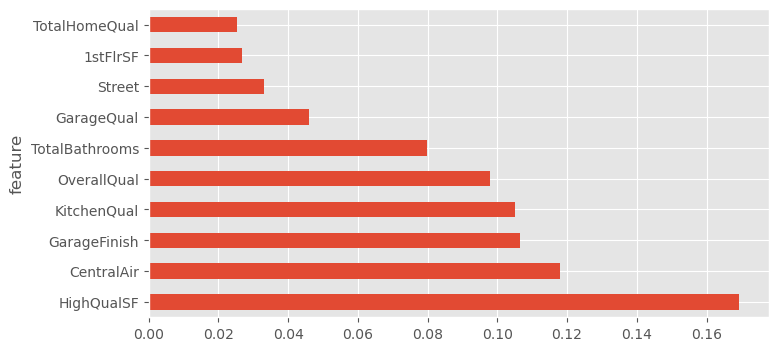

In [224]:
feature_df = pd.DataFrame.from_dict({"feature": model.feature_names_in_, "importance": model.feature_importances_}).sort_values(by="importance", ascending=False)
feature_df[:10].plot(kind="barh", y="importance", x="feature", figsize=(8, 4), legend=False)
plt.show()

# Hyper-parameter tuning

In [225]:
def objective(trial):
    params = {
        "tree_method": trial.suggest_categorical("tree_method", ["gpu_hist"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-3, 10),
        "alpha": trial.suggest_loguniform("alpha", 1e-3, 10),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.3, 1.),
        "subsample": trial.suggest_uniform("subsample", 0.4, 1.0),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
        "max_depth": trial.suggest_categorical("max_depth", np.arange(3, 21, 2)),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
    }
    
    fold_scores = []
    
    for fold in range(N_SPLITS):
        xtrain = train_df.loc[train_df.fold_no != fold, :]
        xvalid = train_df.loc[train_df.fold_no == fold, :]
        ytrain = xtrain.log_SalePrice
        yvalid = xvalid.log_SalePrice
        yvalid_original = xvalid.SalePrice
        
        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]
        
        booster = XGBRegressor(**params, n_estimators=1000, random_state=random_seed)
        booster.fit(xtrain, ytrain, eval_set=[(xvalid, yvalid)], verbose=0)
        
        valid_preds = booster.predict(xvalid)
        valid_preds = [np.expm1(_) for _ in valid_preds]
        # print(f"fold: {fold}, rmse: {mean_squared_log_error(yvalid, valid_preds, squared=False)}")
        fold_scores.append(mean_squared_log_error(yvalid_original, valid_preds, squared=False))
    mean_fold_score = np.mean(fold_scores)
    return mean_fold_score   

In [226]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=600)

[I 2022-09-24 19:02:53,051] A new study created in memory with name: no-name-95902001-1f45-4ce2-94f5-8c7ae616ecf7
[I 2022-09-24 19:02:58,963] Trial 0 finished with value: 0.20233431507900582 and parameters: {'tree_method': 'gpu_hist', 'lambda': 0.36564043708099936, 'alpha': 4.24572595128603, 'colsample_bytree': 0.8163896785677012, 'subsample': 0.767197445838842, 'learning_rate': 0.005103302836508774, 'max_depth': 15, 'min_child_weight': 181}. Best is trial 0 with value: 0.20233431507900582.
[I 2022-09-24 19:03:09,800] Trial 1 finished with value: 0.12987450286615607 and parameters: {'tree_method': 'gpu_hist', 'lambda': 4.17446878142214, 'alpha': 0.01761854094898811, 'colsample_bytree': 0.6211970015531743, 'subsample': 0.46430909273387655, 'learning_rate': 0.008042410966073395, 'max_depth': 15, 'min_child_weight': 26}. Best is trial 1 with value: 0.12987450286615607.
[I 2022-09-24 19:03:26,901] Trial 2 finished with value: 0.24158107131553538 and parameters: {'tree_method': 'gpu_hist', 

In [227]:
print(study.best_params)

{'tree_method': 'gpu_hist', 'lambda': 9.389300430871108, 'alpha': 0.0012048267608698896, 'colsample_bytree': 0.5124265224039863, 'subsample': 0.5852208027212237, 'learning_rate': 0.01261821402911002, 'max_depth': 11, 'min_child_weight': 5}


In [228]:
best_params = {
    'tree_method': 'gpu_hist', 
    'lambda': 0.4299117446427323, 
    'alpha': 0.0010395037326707312, 
    'colsample_bytree': 0.48727717279413846, 
    'subsample': 0.7591218807139135, 
    'learning_rate': 0.012206670519716328, 
    'max_depth': 7, 
    'min_child_weight': 3
}

best_params2 = {
    'tree_method': 'gpu_hist', 
    'lambda': 9.389300430871108, 
    'alpha': 0.0012048267608698896, 
    'colsample_bytree': 0.5124265224039863, 
    'subsample': 0.5852208027212237, 
    'learning_rate': 0.01261821402911002, 
    'max_depth': 11, 
    'min_child_weight': 5}

In [229]:
model = XGBRegressor(**best_params2, n_estimators=1000, random_state=random_seed)
model.fit(train_df[useful_cols], train_df.log_SalePrice, verbose=0)

preds = model.predict(test_df[useful_cols])
preds = [np.expm1(_) for _ in preds]

sample_subm_df["SalePrice"] = preds
sample_subm_df.to_csv("xgb_tuned.csv", index=False)

**Score: 0.12202** after this sumission at the public leaderboard. In top 9%<br>

In [230]:
import joblib

In [232]:
joblib.dump(model, open(result_path / "xgb_model_baseline.gz", "wb"))

# Shap interpretation

In [241]:
import shap

ImportError: Numba needs NumPy 1.21 or less

In [ ]:
explainer = shap.Explainer(model)